In [1]:
import sys
print(sys.executable)

C:\Users\Admin\OneDrive\Documents\Energy_Consumption_Forecasting\myenv\Scripts\python.exe


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
import zipfile
import requests
from io import BytesIO

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set random seed
np.random.seed(42)

In [5]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall("data")

df = pd.read_csv("data/household_power_consumption.txt", sep=';', parse_dates={'Datetime': ['Date', 'Time']},
                 infer_datetime_format=True, low_memory=False, na_values=['?'])
df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)
df.set_index('Datetime', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.interpolate(inplace=True)

Dataset Summary:
       Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.090280e+00           1.236492e-01  2.408328e+02   
std           1.052628e+00           1.124194e-01  3.237763e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.100000e-01           4.800000e-02  2.389900e+02   
50%           6.140000e-01           1.000000e-01  2.410000e+02   
75%           1.528000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06  
mean       4.621481e+00    1.109485e+00    1.289229e+00    6.442386e+00  
std        4.424361e+00    6.115843e+00    5.786613e+00    8.415860e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%      

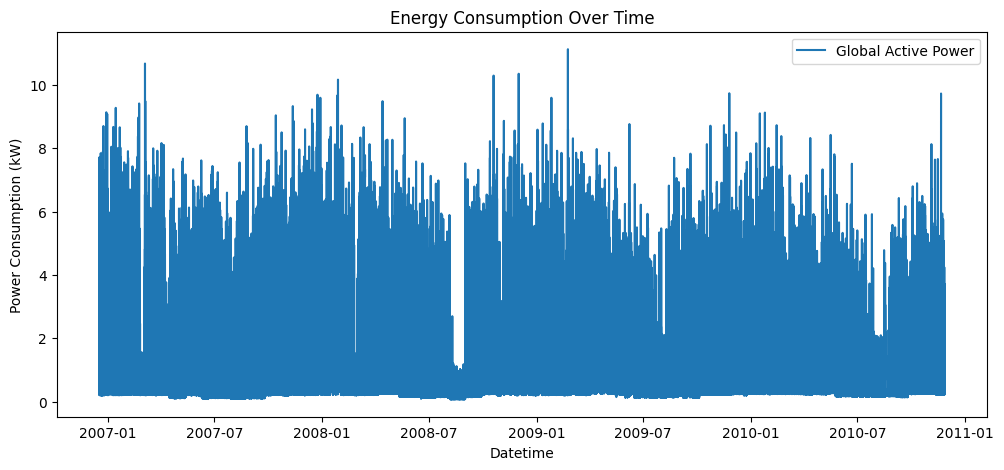

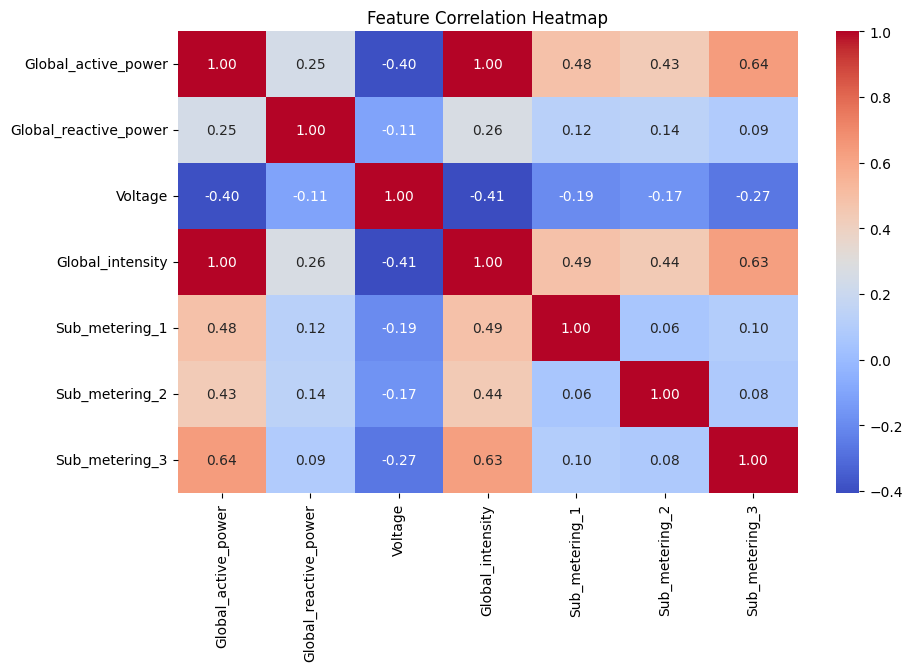

In [6]:
# EDA
print("Dataset Summary:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption (kW)')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

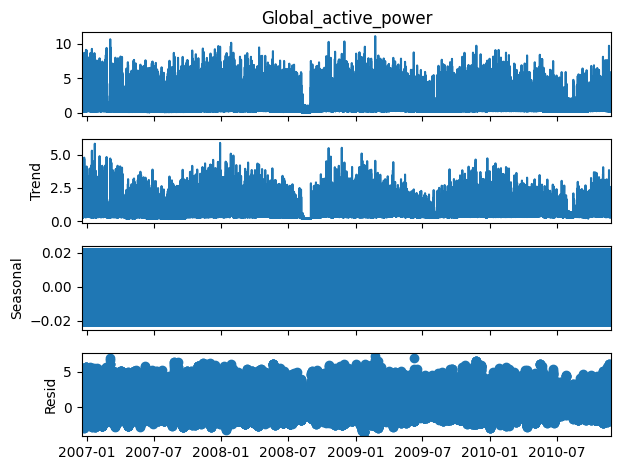

In [7]:
# Seasonal Decomposition
periodicity = 24 if df.index.inferred_freq == 'H' else 168  # Adjust period based on resampling frequency
decomposed = seasonal_decompose(df['Global_active_power'].dropna(), model='additive', period=periodicity)
decomposed.plot()
plt.show()

In [8]:
# Resample data
df_hourly = df.resample('H').mean()
energy_consumption = df_hourly['Global_active_power']
train_size = int(len(energy_consumption) * 0.8)
train, test = energy_consumption[:train_size], energy_consumption[train_size:]

In [9]:
# ARIMA Model
arima_model = ARIMA(train, order=(5,1,0))  # Manually set order
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))[:len(test)]

In [10]:
# Prophet Model
df_prophet = energy_consumption.reset_index()
df_prophet.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(df_prophet.iloc[:train_size])
future = prophet_model.make_future_dataframe(periods=len(test), freq='H', include_history=True)
prophet_forecast = prophet_model.predict(future)['yhat'].iloc[-len(test):].values

21:13:22 - cmdstanpy - INFO - Chain [1] start processing
21:13:49 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# XGBoost Model
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.values.reshape(-1,1))
scaled_test = scaler.transform(test.values.reshape(-1,1))

time_steps = 168
X_train, y_train, X_test, y_test = [], [], [], []
for i in range(time_steps, len(scaled_train)):
    X_train.append(scaled_train[i-time_steps:i, 0])
    y_train.append(scaled_train[i, 0])
for i in range(time_steps, len(scaled_test)):
    X_test.append(scaled_test[i-time_steps:i, 0])
    y_test.append(scaled_test[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
gxgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = RandomizedSearchCV(estimator=gxgb_model, param_distributions=param_grid, cv=3, scoring='neg_mean_absolute_error', n_iter=5, random_state=42)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_
xgb_predictions = best_xgb_model.predict(X_test)

y_test = scaler.inverse_transform(y_test.reshape(-1,1))
xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1,1))
test_adjusted = test.iloc[time_steps:]
xgb_predictions = xgb_predictions[:len(test_adjusted)]

In [13]:
# Evaluation
def evaluate(y_true, y_pred, model_name):
    print(f"{model_name} MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{model_name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"{model_name} MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.2f}%\n")

evaluate(test, arima_forecast, "ARIMA")
evaluate(test, prophet_forecast, "Prophet")
evaluate(test_adjusted, xgb_predictions, "XGBoost")

ARIMA MAE: 0.5851
ARIMA RMSE: 0.8108
ARIMA MAPE: 61.04%

Prophet MAE: 0.4883
Prophet RMSE: 0.6388
Prophet MAPE: 73.28%

XGBoost MAE: 0.3279
XGBoost RMSE: 0.4766
XGBoost MAPE: 42.96%



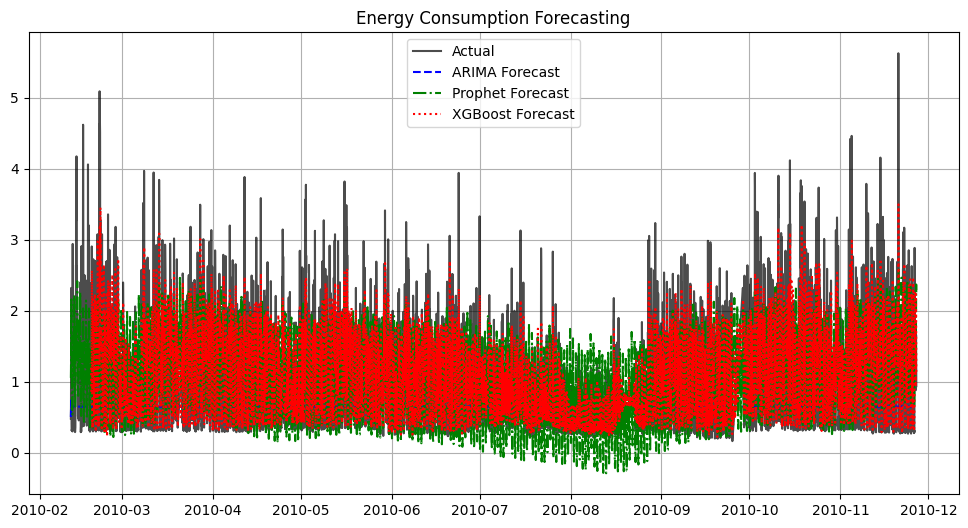

In [14]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual', linestyle='-', color='black', alpha=0.7)
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.plot(test.index, prophet_forecast, label='Prophet Forecast', linestyle='-.', color='green')
plt.plot(test.index[time_steps:], xgb_predictions, label='XGBoost Forecast', linestyle=':', color='red')
plt.legend()
plt.grid(True)
plt.title('Energy Consumption Forecasting')
plt.show()